<a href="https://colab.research.google.com/github/mikekrestas/House-Price-Prediction-Program/blob/master/5thsubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/hrshtporwal5/houseprice-prediction

import numpy as np # linear algebra
import pandas as pd # data processing


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


from datetime import datetime

from scipy.stats import skew  # for statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from mlxtend.regressor import StackingCVRegressor


# regression: a measure of the relation between the mean value of one variable (e.g., output) and corresponding values of other variables
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import pandas_profiling 

import seaborn as sns
import matplotlib.style as style
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing train data
train = pd.read_csv("train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Import test data.
test = pd.read_csv("test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
house_train= pd.read_csv('train.csv')
house_test= pd.read_csv('test.csv')
train_len = len(house_train)

In [ ]:
def customized_scatterplot(y, x):
        ## Sizing the plot. 
    style.use('fivethirtyeight')
    plt.subplots(figsize = (15,10))
    ## Plotting target variable with predictor variable(OverallQual)
    sns.scatterplot(y = y, x = x);

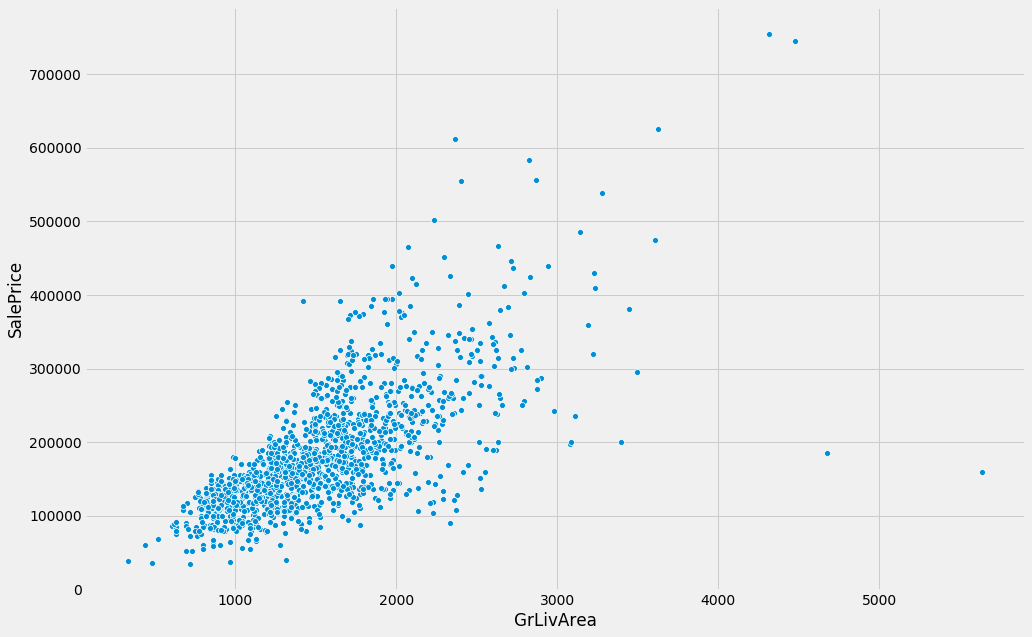

In [ ]:
# From this scatter plot we see two outliers, that need to be removed
customized_scatterplot(train.SalePrice, train.GrLivArea)

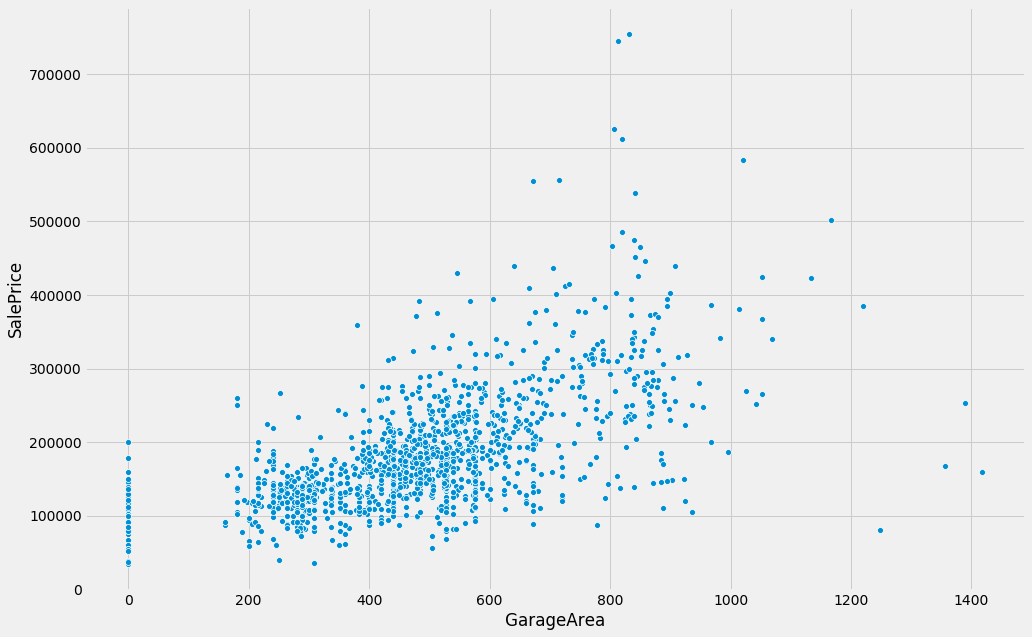

In [ ]:
# As well as here, there are multiple outliers that need to be removed.
customized_scatterplot(train.SalePrice, train.GarageArea);

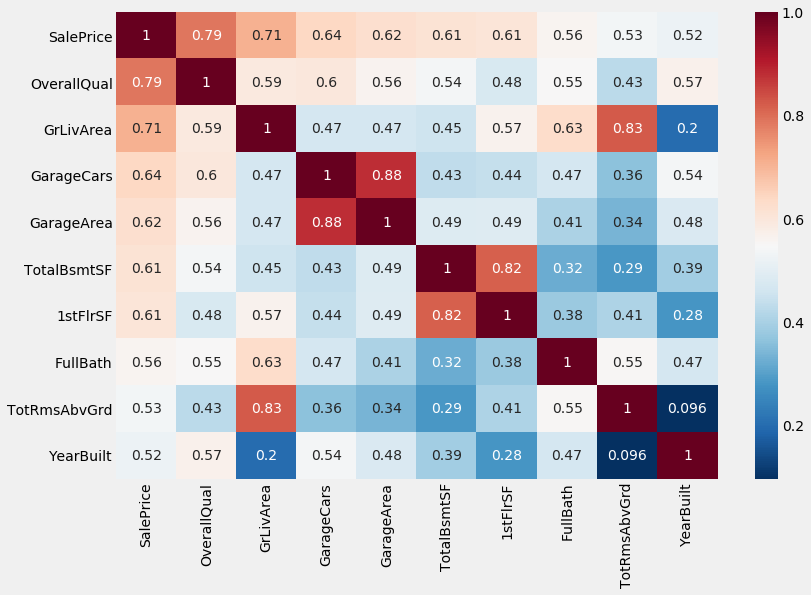

In [ ]:
k = 10
cols = house_train.corr().nlargest(k, 'SalePrice')['SalePrice'].index
k_corr_matrix = house_train[cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(k_corr_matrix, annot=True, cmap=plt.cm.RdBu_r)

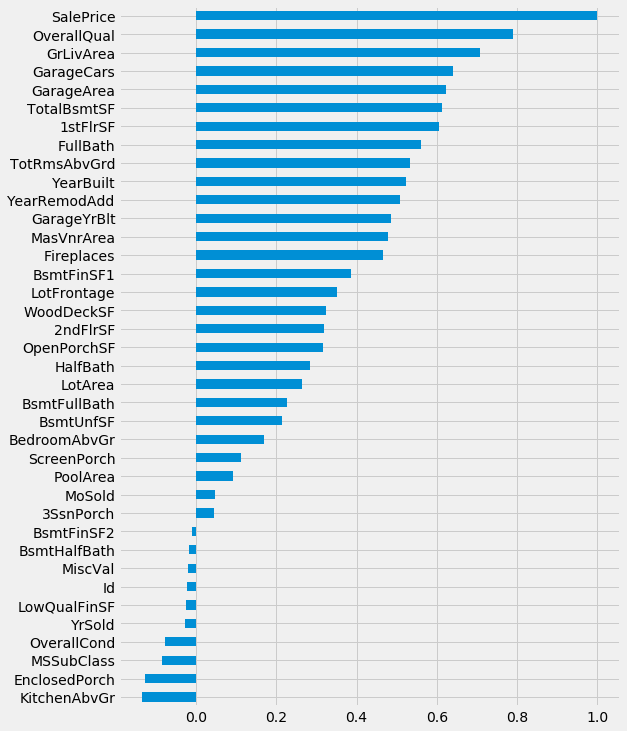

In [ ]:
plt.figure(figsize=(8, 12))
house_train.corr()['SalePrice'].sort_values().plot(kind='barh')

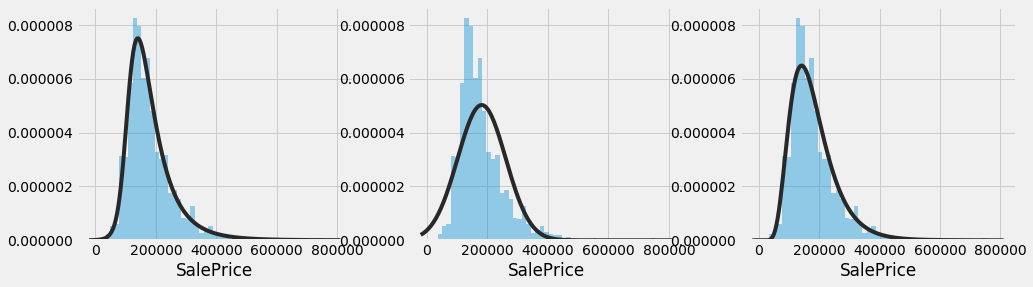

In [ ]:
#Is Target variable Normal?
y = house_train['SalePrice']
f, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.distplot(y, kde=False, fit=stats.johnsonsu, ax=axes[0])
sns.distplot(y, kde=False, fit=stats.norm, ax=axes[1])
sns.distplot(y, kde=False, fit=stats.lognorm, ax=axes[ 2])

In [ ]:
# applying log transformation
house_train['SalePriceLog'] = np.log1p(house_train['SalePrice'])

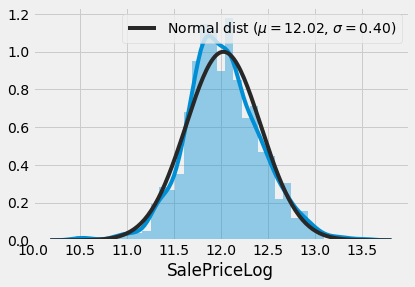

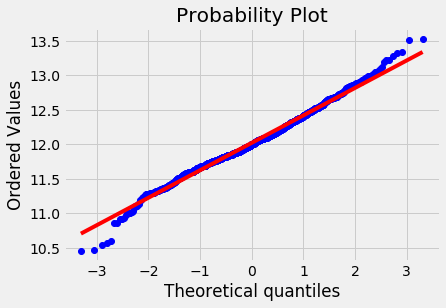

In [ ]:
# distribution histogram and normal probability plot
(mu, sigma) = norm.fit(house_train['SalePriceLog'])

sns.distplot(house_train['SalePriceLog'], fit=norm)
plt.legend(['Normal dist ($\mu=${:.2f}, $\sigma=${:.2f})'.format(mu, sigma)])

fig = plt.figure()
stats.probplot(house_train['SalePriceLog'], plot=plt)
plt.show()

outer range (low) of the distribution: 
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]
outer range (high) of the distribution: 
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


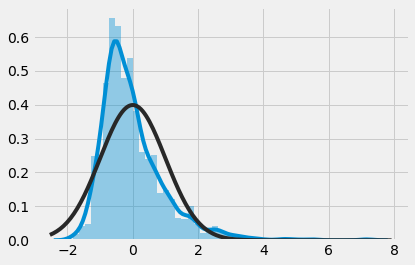

In [ ]:
sale_price_scaled = StandardScaler().fit_transform(house_train['SalePrice'][:, np.newaxis])

sns.distplot(sale_price_scaled, fit=norm)

low_range = sale_price_scaled[sale_price_scaled[:, 0].argsort()[:10]]
high_range = sale_price_scaled[sale_price_scaled[:, 0].argsort()[-10:]]
print(f'outer range (low) of the distribution: \n{low_range}')
print(f'outer range (high) of the distribution: \n{high_range}')


In [ ]:
#Removing outliers 
house_train = house_train[house_train['GrLivArea'] < 4000]

In [ ]:
#Separating qualitative(categorical) and quantitative(continuous) featues
quantitative = [feature for feature in house_train.columns if house_train.dtypes[feature] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [feature for feature in house_train.columns if house_train.dtypes[feature] == 'object']

In [ ]:
# Combining train and test datasets
house_train.reset_index(drop=True, inplace=True)
y_train = house_train['SalePriceLog']
X_train = house_train.drop(['SalePrice', 'SalePriceLog'], axis=1)
X_test = house_test

In [ ]:
all_data = pd.concat([X_train, house_test], axis=0, sort=False)
all_data.drop(['Id'], axis=1, inplace=True)
all_data.shape

(2915, 79)

In [ ]:
#Calculating missing data
na_total = all_data.isnull().sum().sort_values(ascending=False)
na_ratio = (all_data.isnull().sum() / all_data.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([na_total, na_ratio], axis=1, keys=['Total', 'Ratio'])
missing_data.head(50)

,Total,Ratio
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageCond,159,0.054545
GarageQual,159,0.054545
GarageYrBlt,159,0.054545
GarageFinish,159,0.054545


In [ ]:
# Most value of these 4 features are missing and they have no pattern , just delete them
all_data.drop(['PoolQC', 'Utilities', 'Street', 'MiscFeature', ], axis=1, inplace=True)

In [ ]:
#Filling NA with None for categorical features
for col in ('Alley','Fence','FireplaceQu','GarageQual','GarageFinish','GarageCond','GarageType','BsmtExposure',
          'BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1'):
     all_data[col] = all_data[col].fillna(0)

In [ ]:
all_data['MasVnrType'].fillna('None', inplace=True)
all_data['HasMasVnr'] = all_data['MasVnrType'].apply(lambda x: 0 if x == 'None' else 1)
all_data['MSZoning'] = all_data.groupby(['MSSubClass'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

for col in ('Functional','Exterior1st','Electrical','KitchenQual','SaleType','Exterior2nd'):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [ ]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
all_data['GarageYrBlt'] = (all_data['YearBuilt'] + all_data['YearRemodAdd']) /2
all_data['MasVnrArea'] = all_data.groupby(['MasVnrType'])['MasVnrArea'].transform(lambda x: x.fillna(x.median()))

In [ ]:
print(all_data[all_data['GarageCars'].isnull()][['GarageArea', 'GarageCars', 'GarageType', 'GarageYrBlt', 'GarageQual']])
all_data['GarageArea'].fillna(0, inplace=True)
all_data['GarageCars'].fillna(0, inplace=True)

      GarageArea  GarageCars GarageType  GarageYrBlt GarageQual
1116         NaN         NaN     Detchd       1961.0          0


In [ ]:
print(all_data[all_data['TotalBsmtSF'].isnull()][
    ['TotalBsmtSF', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFullBath','BsmtHalfBath']])
for col in ('TotalBsmtSF', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFinSF1', 'BsmtFullBath','BsmtHalfBath'):
     all_data[col] = all_data[col].fillna(0)
# all_data['TotalBsmtSF'].fillna(0, inplace=True)
# all_data['BsmtUnfSF'].fillna(0, inplace=True)
# all_data['BsmtFinSF1'].fillna(0, inplace=True)
# all_data['BsmtFinSF2'].fillna(0, inplace=True)
# all_data['BsmtFullBath'].fillna(0, inplace=True)
# all_data['BsmtHalfBath'].fillna(0, inplace=True)

     TotalBsmtSF  BsmtFinSF2  BsmtUnfSF  BsmtFinSF1  BsmtFullBath  BsmtHalfBath
660          NaN         NaN        NaN         NaN           NaN           NaN


In [ ]:
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']
all_data['TotalSF']=all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalSqrFootage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])
all_data['TotalBathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

In [ ]:
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [ ]:
all_data = pd.get_dummies(all_data).reset_index(drop=True)

In [ ]:
all_data.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,HasMasVnr,YrBltAndRemod,TotalSF,TotalSqrFootage,TotalBathrooms,TotalPorchSF,has2ndfloor,...,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_0,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,1,4006,2566.0,2416.0,3.5,61,1,...,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,0,3952,2524.0,2240.0,2.5,298,0,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.5,2.0,608.0,0,42,0,0,0,0,0,1,4003,2706.0,2272.0,3.5,42,1,...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1942.5,3.0,642.0,0,35,272,0,0,0,0,0,3885,2473.0,1933.0,2.0,307,1,...,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,1,4000,3343.0,2853.0,3.5,276,1,...,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
all_data.isnull().sum().sort_values(ascending=False)

SaleCondition_Partial    0
Neighborhood_Sawyer      0
Neighborhood_Somerst     0
Neighborhood_StoneBr     0
Neighborhood_Timber      0
                        ..
BsmtFinType1_GLQ         0
BsmtFinType1_LwQ         0
BsmtFinType1_Rec         0
BsmtFinType1_Unf         0
LotFrontage              0
Length: 328, dtype: int64

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import ElasticNet, Lasso, Ridge, ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR


# XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. It is usually used for regression.
from xgboost import XGBRegressor

# Light GBM is a gradient boosting framework that uses tree based learning algorithm. Light GBM can handle the large size of data and takes lower memory to run
# Also it is much faster than the XGBoost.
from lightgbm import LGBMRegressor 

# The mlxtend.regressor uses out-of-fold predictions to prepare the input data for the level-2 regressor. 
from mlxtend.regressor import StackingCVRegressor

In [ ]:
X_train = all_data.iloc[:len(y_train), :]
X_test = all_data.iloc[len(y_train):, :]

In [ ]:
X_train.shape, y_train.shape, X_test.shape

((1456, 328), (1456,), (1459, 328))

In [ ]:
#cross_val_score to get the root mean square error, which is the score method for current regression problem
def rmse_cv(model):
    mse = cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=5)
    rmse = np.sqrt(-mse)
    print(f'{model.__class__.__name__} score: {rmse.mean():.4f}, {rmse.std():.4f}')
    #return(rmse)

In [ ]:
lasso = Lasso()
lasso_search = GridSearchCV(lasso, {'alpha': np.logspace(-4, -3, 5)}, cv=5, scoring="neg_mean_squared_error")
lasso_search.fit(X_train, y_train)
lasso_search.best_estimator_

Lasso(alpha=0.0005623413251903491, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso_model = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
rmse_cv(lasso_model)

Pipeline score: 0.1114, 0.0067


In [ ]:
ridge = Ridge()
ridge_search = GridSearchCV(ridge, {'alpha': np.linspace(10, 30, 10)}, cv=5, scoring="neg_mean_squared_error")
ridge_search.fit(X_train, y_train)
ridge_search.best_estimator_

Ridge(alpha=18.88888888888889, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
ridge_model = make_pipeline(RobustScaler(), Ridge(alpha=19))
rmse_cv(ridge_model)

Pipeline score: 0.1148, 0.0062


In [ ]:
enet = ElasticNet()
enet_search = GridSearchCV(enet, {'alpha': np.linspace(0.0001, 0.001, 10), 'l1_ratio':np.linspace(0.5, 1.5, 10)},
                           cv=5, scoring="neg_mean_squared_error")
enet_search.fit(X_train, y_train)
enet_search.best_estimator_

ElasticNet(alpha=0.00039999999999999996, copy_X=True, fit_intercept=True,
           l1_ratio=1.3888888888888888, max_iter=1000, normalize=False,
           positive=False, precompute=False, random_state=None,
           selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
enet_model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0004, l1_ratio=1.4, random_state=3))
rmse_cv(enet_model)

Pipeline score: 0.1114, 0.0065


In [ ]:
gbdt_model = GradientBoostingRegressor(learning_rate=0.05, min_samples_leaf=5, min_samples_split=10,
                                       max_depth=4, n_estimators=3000)
rmse_cv(gbdt_model)

GradientBoostingRegressor score: 0.1202, 0.0059


In [ ]:
rf_model = RandomForestRegressor(min_samples_leaf=4, min_samples_split=8)
rmse_cv(rf_model)

RandomForestRegressor score: 0.1360, 0.0034


In [ ]:
svr_model = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.005, gamma=0.0003))
rmse_cv(svr_model)

Pipeline score: 0.1746, 0.0105


In [ ]:
xgb_model = XGBRegressor(learning_rate=0.01, max_depth=5, n_estimators=3000, 
                         n_thread=-1, n_jobs=-1, objective='reg:squarederror')
rmse_cv(xgb_model)

XGBRegressor score: 0.1187, 0.0045


In [ ]:
lgb_model = LGBMRegressor(objective='regression',
                    learning_rate=0.01, max_depth=5, num_leaves=4, 
                    n_estimators=3000)
rmse_cv(lgb_model)

LGBMRegressor score: 0.1182, 0.0043


In [ ]:
stack_model = StackingCVRegressor([lasso_model, ridge_model, enet_model, gbdt_model, rf_model, svr_model, xgb_model, lgb_model], 
                                  meta_regressor=lgb_model,
                                  use_features_in_secondary=True)
# rmse_cv(stack_model)

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
#models stacked
lasso_model = lasso_model.fit(X_train, y_train)
ridge_model = ridge_model.fit(X_train, y_train)
enet_model = enet_model.fit(X_train, y_train)
gbdt_model = gbdt_model.fit(X_train, y_train)
rf_model = rf_model.fit(X_train, y_train)
svr_model = svr_model.fit(X_train, y_train)
xgb_model = xgb_model.fit(X_train, y_train)
lgb_model = lgb_model.fit(X_train, y_train)
stack_model = stack_model.fit(np.array(X_train), np.array(y_train))

In [ ]:
#Prediction
def combine_models_predict(X):
    return ((0.1 * enet_model.predict(X)) + \
            (0.1 * ridge_model.predict(X)) + \
            (0.1 * lasso_model.predict(X)) + \
            (0.15 * gbdt_model.predict(X)) + \
            (0.15 * xgb_model.predict(X)) + \
            (0.1 * lgb_model.predict(X)) + \
            (0.075 * rf_model.predict(X)) + \
            (0.075 * svr_model.predict(X)) + \
            (0.15 * stack_model.predict(np.array(X)))
           )

In [ ]:
print('RMSLE score on train data:')
print(rmsle(y_train, combine_models_predict(X_train)))

RMSLE score on train data:
0.05749022600077932


In [ ]:
log_result = combine_models_predict(X_test)
result = np.expm1(log_result)

In [ ]:
#Submission
sub = pd.DataFrame()
sub['Id'] = house_test['Id']
sub['SalePrice'] = result
sub.head()

In [ ]:
sub.to_csv('houseprice_submission.csv',index=False)